# Classification of Bricks
## *Find the best model*

![bricks](https://i.imgur.com/UxJnflV.png)

# Table of contents

[<h3>1. Data preprocessing and visualization</h3>](#1)

[<h3>2. Load the Images with a generator and Data Augmentation</h3>](#2)

[<h3>3. Test 20 canned architectures with pre-trained weights</h3>](#3)

[<h3>4. Train the best architecture</h3>](#4)

[<h3>5. Examples of prediction</h3>](#5)

Julio Elias, Pablo Chaves, Rodolfo Jaramillo, Luis Ortiz

# 1. Data preprocessing and visualization<a class="anchor" id="1"></a>

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [ ]:
# Create a list with the filepaths for training and testing
dir_ = Path('../input/lego-brick-images/dataset')
file_paths = list(dir_.glob(r'**/*.png'))
file_paths = [str(x) for x in file_paths]
df = pd.DataFrame({'Filepath':file_paths})

In [ ]:
def get_label(string):
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[1:-1])
    string = string.lower()
    return string

# Retrieve the label from the path of the pictures
df['Label'] = df['Filepath'].apply(lambda x: get_label(x))

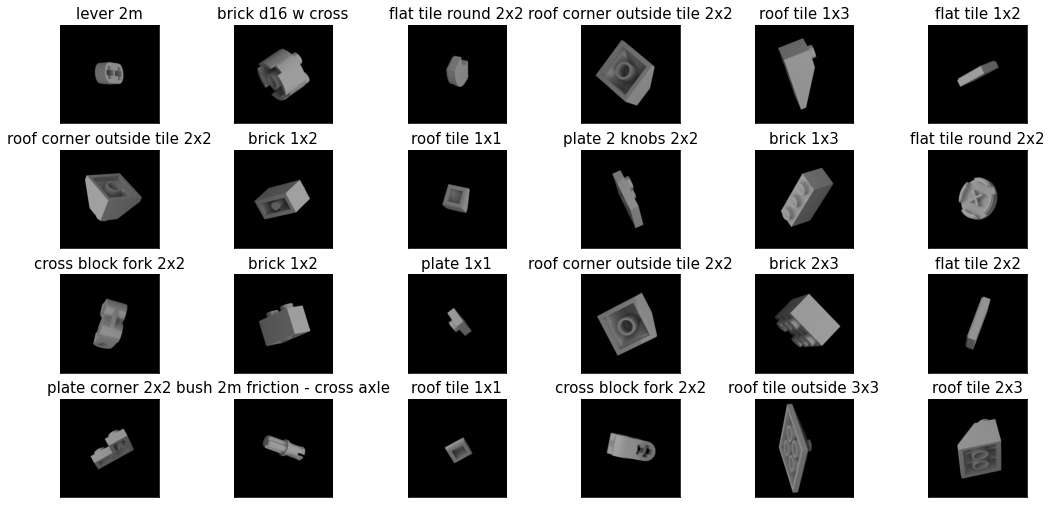

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

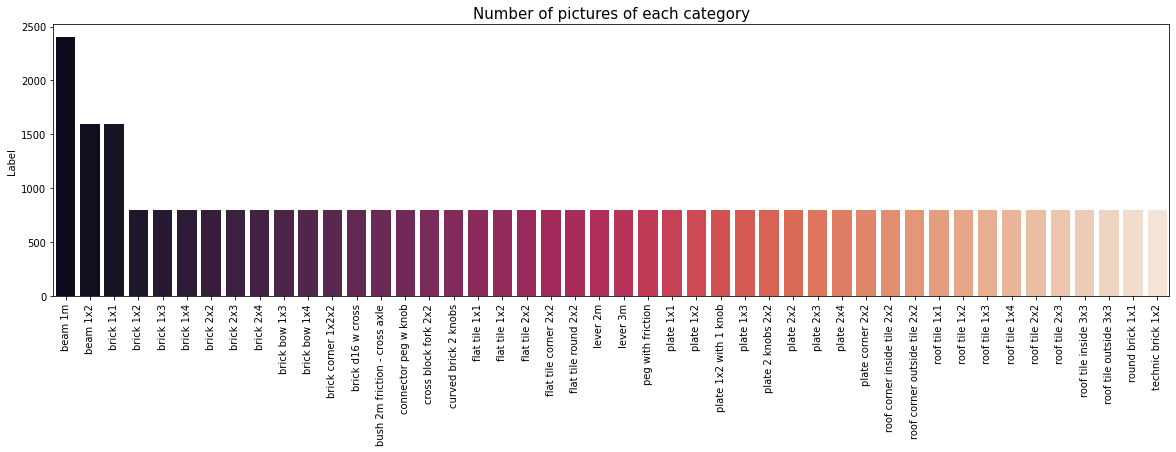

In [ ]:
# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Load the paths of the validation set
validation = pd.read_csv('../input/lego-brick-images/validation.txt', names = ['Filepath'])
validation['Filepath'] = validation['Filepath'].apply(lambda x: '../input/lego-brick-images/dataset/' + x)
validation.head()

,Filepath
0,../input/lego-brick-images/dataset/14719 flat ...
1,../input/lego-brick-images/dataset/14719 flat ...
2,../input/lego-brick-images/dataset/14719 flat ...
3,../input/lego-brick-images/dataset/14719 flat ...
4,../input/lego-brick-images/dataset/14719 flat ...


In [ ]:
# The paths of the validation set is already in the DataFrame df
# Create a new column "validation_set" to indicate which
# paths of picture should be in the training and validation set
df['validation_set'] = df['Filepath'].isin(validation['Filepath'])
df.head()

,Filepath,Label,validation_set
0,../input/lego-brick-images/dataset/41677 lever...,lever 2m,False
1,../input/lego-brick-images/dataset/6143 Brick ...,brick d16 w cross,False
2,../input/lego-brick-images/dataset/27925 flat ...,flat tile round 2x2,False
3,../input/lego-brick-images/dataset/3045 roof c...,roof corner outside tile 2x2,False
4,../input/lego-brick-images/dataset/4286 roof t...,roof tile 1x3,False


In [ ]:
# Create a DataFrame for the training set
# and for the test set. What is called "validation set"
# will be used as test set in the workbook
# Use only 30% of the data to speed up the model tests
train_df = df[df['validation_set'] == False].sample(frac = 0.3)
test_df = df[df['validation_set'] == True].sample(frac = 0.3)

In [ ]:
a = 0
printmd(f'### Number of pictures in the train set: {train_df.shape[0]}')
printmd(f'### Number of pictures in the test set: {test_df.shape[0]}')

### Number of pictures in the train set: 9600

### Number of pictures in the test set: 2400

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a><a class="anchor" id="1"></a>

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test 20 canned architectures with pre-trained weights<a class="anchor" id="3"></a><a class="anchor" id="1"></a>

More info about the architectures under: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=enhttps://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en)

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(46, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 8640 validated image filenames belonging to 46 classes.
Found 960 validated image filenames belonging to 46 classes.
Found 2400 validated image filenames belonging to 46 classes.


270/270 [==============================] - 68s 215ms/step - loss: 2.8610 - accuracy: 0.2441 - val_loss: 1.3657 - val_accuracy: 0.5594
DenseNet121          trained in 67.96 sec
270/270 [==============================] - 39s 133ms/step - loss: 2.7298 - accuracy: 0.2735 - val_loss: 1.1385 - val_accuracy: 0.6313
MobileNetV2          trained in 38.83 sec
270/270 [==============================] - 49s 154ms/step - loss: 2.7466 - accuracy: 0.2744 - val_loss: 1.2362 - val_accuracy: 0.5938
DenseNet169          trained in 49.65 sec
270/270 [==============================] - 53s 159ms/step - loss: 2.7310 - accuracy: 0.2676 - val_loss: 1.1787 - val_accuracy: 0.6052
DenseNet201          trained in 53.09 sec
270/270 [==============================] - 53s 163ms/step - loss: 2.9382 - accuracy: 0.2191 - val_loss: 1.687

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,MobileNet,0.6354,36.87
1,MobileNetV2,0.6313,38.83
2,DenseNet201,0.6052,53.09
3,ResNet50V2,0.5979,41.21
4,DenseNet169,0.5938,49.65
5,ResNet101V2,0.5781,45.43
6,DenseNet121,0.5594,67.96
7,ResNet152V2,0.5562,54.51
8,Xception,0.5021,39.79
9,InceptionV3,0.4958,41.18


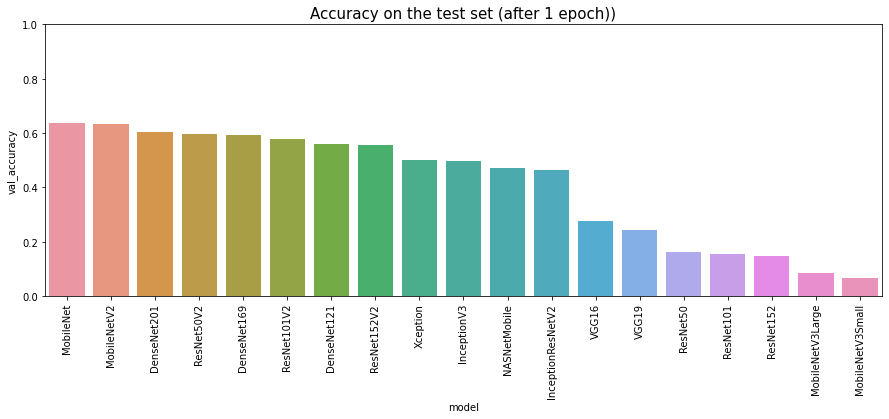

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

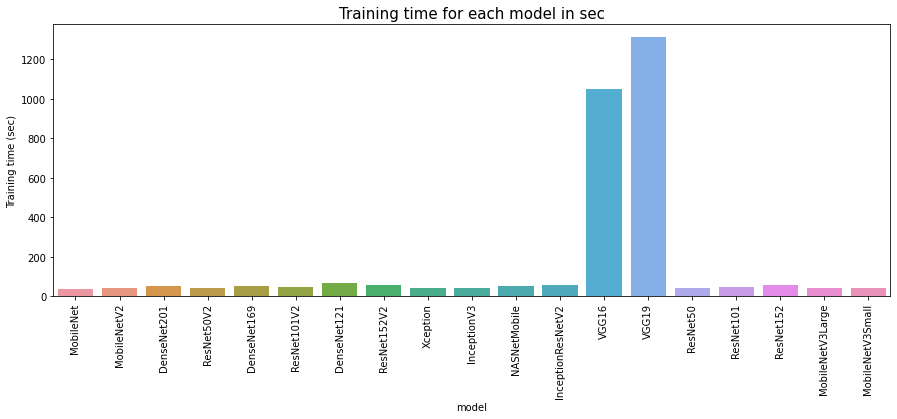

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Train the architecture with the best result<a class="anchor" id="4"></a>
*With more than one epoch*

In [ ]:
# Use the whole data which is split into training and test datasets
# Create a DataFrame for the training set
# and for the test set. What is called "validation set"
# will be used as test set in the workbook
train_df = df[df['validation_set'] == False]
test_df = df[df['validation_set'] == True]

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Get the model with the highest validation score
best_model = df_results.iloc[0]

# Create a new model
model = get_model( eval("tf.keras.applications."+ best_model[0]) )

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=20,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)]
                    )

Found 28800 validated image filenames belonging to 46 classes.
Found 3200 validated image filenames belonging to 46 classes.
Found 8000 validated image filenames belonging to 46 classes.
Epoch 1/20
900/900 [==============================] - 199s 220ms/step - loss: 1.8513 - accuracy: 0.4727 - val_loss: 0.7538 - val_accuracy: 0.7403
Epoch 2/20
900/900 [==============================] - 115s 128ms/step - loss: 0.6141 - accuracy: 0.7905 - val_loss: 0.5673 - val_accuracy: 0.8059
Epoch 3/20
900/900 [==============================] - 116s 129ms/step - loss: 0.4733 - accuracy: 0.8337 - val_loss: 0.4982 - val_accuracy: 0.8213
Epoch 4/20
900/900 [==============================] - 116s 129ms/step - loss: 0.4088 - accuracy: 0.8550 - val_loss: 0.5060 - val_accuracy: 0.8238
Epoch 5/20
900/900 [==============================] - 125s 139ms/step - loss: 0.3635 - accuracy: 0.8689 - val_loss: 0.4963 - val_accuracy: 0.8238
Epoch 6/20
900/900 [==============================] - 118s 131ms/step - loss: 0.314

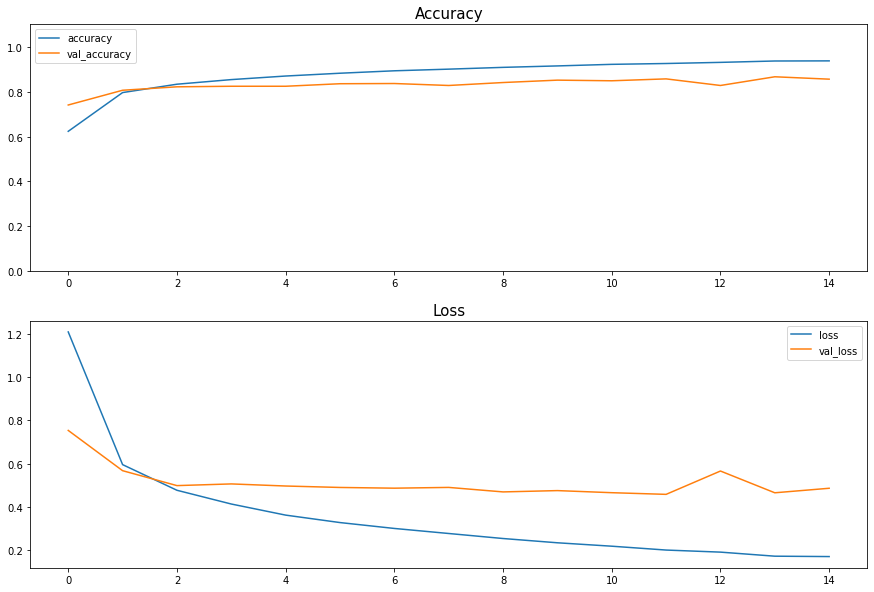

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set')

## Best Model: MobileNet with 85.69% accuracy on the test set

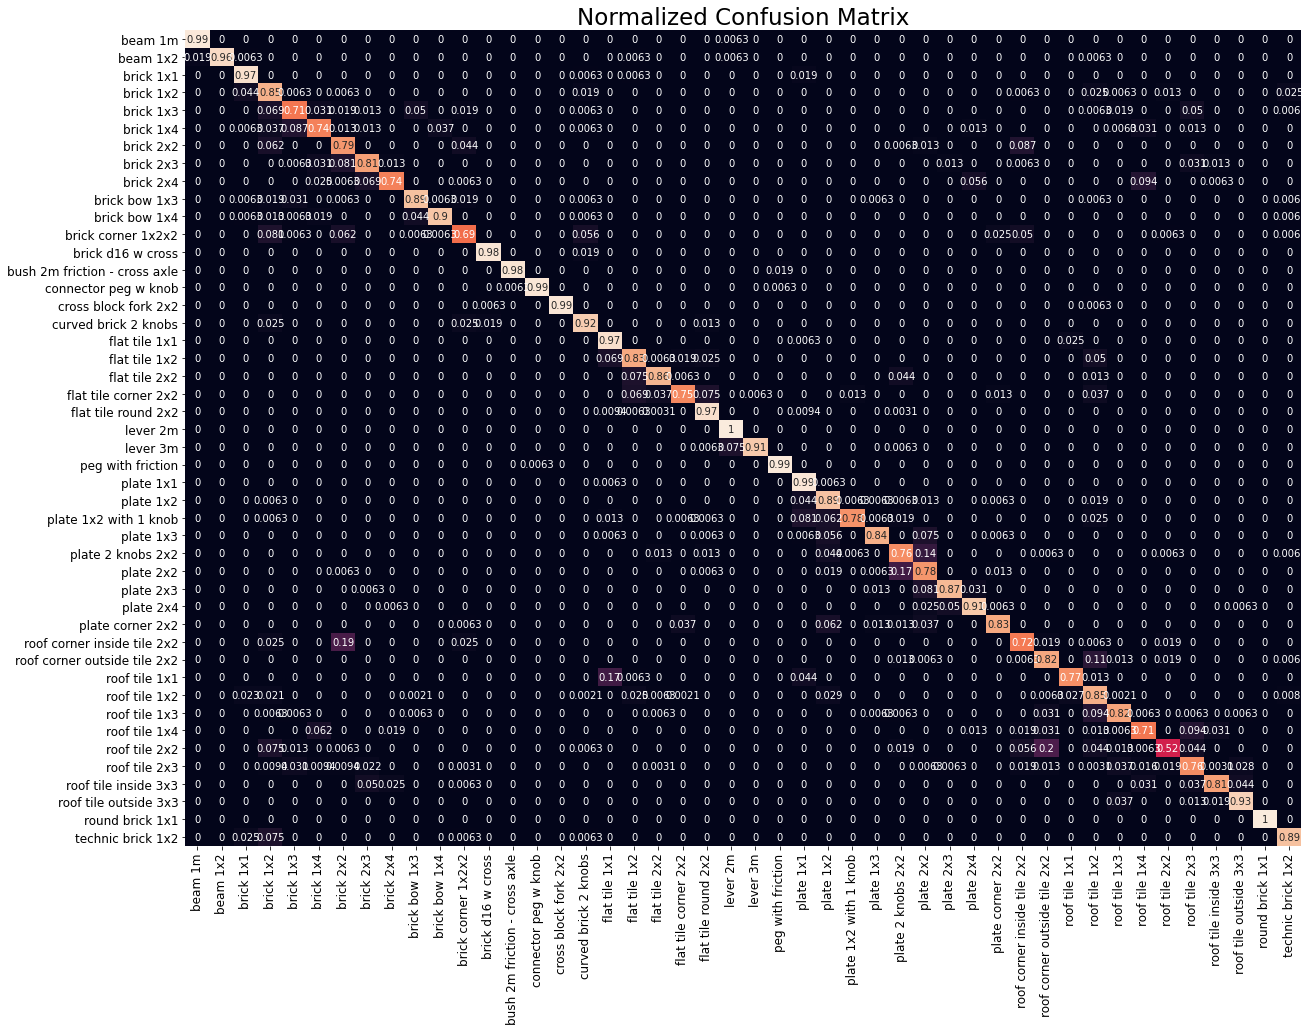

In [ ]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12)
plt.show()

# 5. Examples of prediction<a class="anchor" id="5"></a>


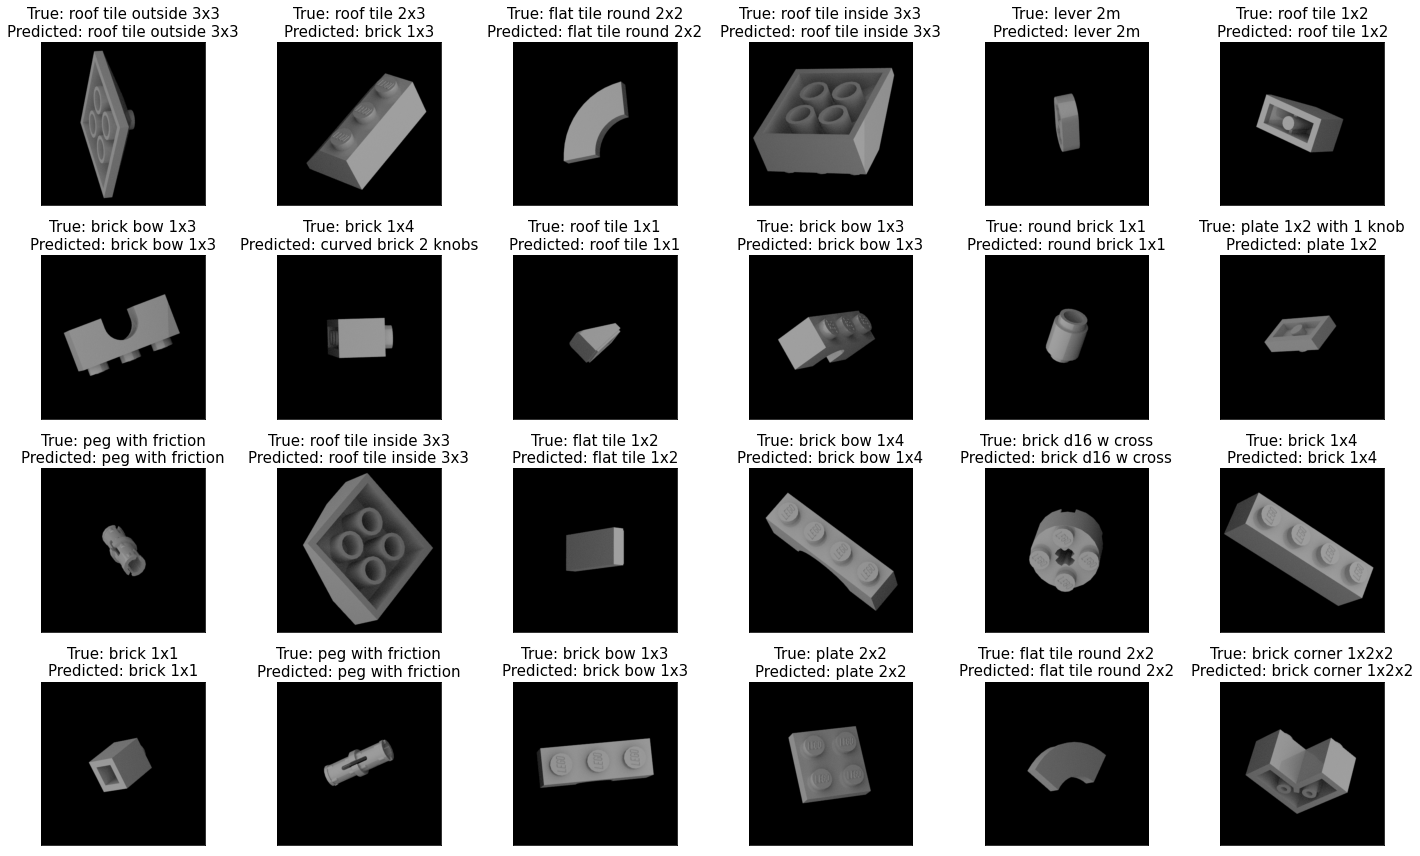

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()